In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight

RANDOM_STATE_SEED = 12

In [ ]:
!pip install keras==2.12.0
!pip install scikeras
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
# from keras.losses import SparseCategoricalCrossentropy
from scikeras.wrappers import KerasClassifier
from keras import callbacks,layers

import time

In [ ]:
df = pd.read_csv('02-16-2018.csv')

# Data Cleaning

In [ ]:
# replace +ve and -ve infinity with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop all NaN values
df.dropna(inplace=True)

In [ ]:
count = df['Label'].value_counts()
print(f"Value counts for dataframe:\n{count}\n")

Value counts for dataframe:
DoS attacks-Hulk            352969
Benign                      335331
DoS attacks-SlowHTTPTest     91434
Name: Label, dtype: int64



In [ ]:
#converting Timestamp values to pandas date and time format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

In [ ]:
#converted to epoch format
df['Timestamp'] = (df['Timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [ ]:
for col in df.columns:
    #Check if the datatype of the column is object
    if df[col].dtype == 'object' and col != 'Label':
        # Change all values to numeric, and to NaN if it is a string
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
#drop NaN values
print(df.isna().sum())
df.dropna(inplace=True)

Dst Port         0
Protocol         0
Timestamp        0
Flow Duration    0
Tot Fwd Pkts     0
                ..
Idle Mean        0
Idle Std         0
Idle Max         0
Idle Min         0
Label            0
Length: 80, dtype: int64


In [ ]:
#Filter out outliers
from scipy import stats

# Define a function to filter outliers using Z-score
def filter_outliers_zscore(data, threshold):
    z_scores = np.abs(stats.zscore(data))
    outlier_mask = (z_scores > threshold).any(axis=1)
    return data[~outlier_mask], data[outlier_mask]

# Define a threshold value
threshold = 7

# Loop through the columns of the dataframe and filter outliers in each column
filtered_cols = []
removed_outliers = []
for col in df.columns:
    if col != 'Label':
        filtered_col, outliers = filter_outliers_zscore(df[[col]], threshold)

        filtered_cols.append(filtered_col)
        removed_outliers.append(outliers)

# Combine the filtered columns back into a dataframe
df_filtered = pd.concat(filtered_cols, axis=1)

# Combine the removed outliers back into a dataframe
df_outliers = pd.concat(removed_outliers, axis=1)

# Dataframe filtering comparison

print(f'\nDataframe Shape: {df.shape}')

# Print the number of outliers removed for each column

print('Outlier removal summary:')
n_outliers = df_outliers.shape[0]
print(f'{n_outliers} outliers rows to be removed')

# Print the original dataframe and the filtered dataframe side by side
print('\nOriginal dataframe:')
display(df.head())

# Assign filtered dataframe columns to original one
columns = [col for col in df.columns if col != 'Label']
df.loc[:,columns] = df_filtered.loc[:,columns]

print('\nFiltered dataframe:')
display(df.head())

# Print the removed outliers dataframe
print('\nRemoved outliers:')
display(df_outliers.head())

# Count how many rows of each attack were removed from original dataframe
values_orig = df.loc[df.index.isin(df_outliers.index), 'Label']
print(f'\n{values_orig.value_counts()}')

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


Dataframe Shape: (779734, 80)
Outlier removal summary:
9841 outliers rows to be removed

Original dataframe:


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,1518769643,112640768,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,56300000.0,138.592929,56300000.0,56300000.0,Benign
1,0,0,1518769812,112641773,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,56300000.0,263.750829,56300000.0,56300000.0,Benign
2,35605,6,1518769615,20784143,23,44,2416,1344,240,64,...,20.0,2624734.0,0.0,2624734.0,2624734.0,9058214.0,0.000000,9058214.0,9058214.0,Benign
3,0,0,1518769981,112640836,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,56300000.0,82.024387,56300000.0,56300000.0,Benign
4,23,6,1518769679,20,1,1,0,0,0,0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign



Filtered dataframe:


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,NaN,1518769643,NaN,3.0,0.0,0.0,0.0,0,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,138.592929,NaN,NaN,Benign
1,0,NaN,1518769812,NaN,3.0,0.0,0.0,0.0,0,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,263.750829,NaN,NaN,Benign
2,35605,6.0,1518769615,20784143.0,NaN,NaN,2416.0,1344.0,240,NaN,...,20.0,NaN,0.0,NaN,NaN,9058214.0,0.000000,9058214.0,9058214.0,Benign
3,0,NaN,1518769981,NaN,3.0,0.0,0.0,0.0,0,0.0,...,NaN,0.0,0.0,0.0,0.0,NaN,82.024387,NaN,NaN,Benign
4,23,6.0,1518769679,20.0,1.0,1.0,0.0,0.0,0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign



Removed outliers:


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,NaN,0.0,NaN,112640768.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,56300000.0,NaN,56300000.0,56300000.0
1,NaN,0.0,NaN,112641773.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,56300000.0,NaN,56300000.0,56300000.0
3,NaN,0.0,NaN,112640836.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,56300000.0,NaN,56300000.0,56300000.0
5,NaN,0.0,NaN,112641178.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,56300000.0,NaN,56300000.0,56300000.0
6,NaN,0.0,NaN,112641264.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,56300000.0,NaN,56300000.0,56300000.0



Benign                      5874
DoS attacks-Hulk            3304
DoS attacks-SlowHTTPTest     663
Name: Label, dtype: int64


In [ ]:
display(df.describe())

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,769893.000000,769893.0,7.698930e+05,7.698930e+05,769893.000000,769893.000000,769893.000000,769893.000000,769893.000000,769893.0,...,769893.000000,769893.000000,769893.000000,769893.0,769893.000000,769893.000000,7.698930e+05,769893.0,7.698930e+05,7.698930e+05
mean,20168.396473,6.0,1.518749e+09,1.949679e+06,3.236029,1.640810,406.367925,191.053854,405.791726,0.0,...,0.451481,32.933013,1.294812,0.0,1.294812,1.294812,3.393704e+05,0.0,3.393704e+05,3.393704e+05
std,23836.925099,0.0,1.023214e+04,2.242926e+06,1.571020,1.670192,458.155063,249.694234,457.892031,0.0,...,0.501890,2.607196,137.115886,0.0,137.115886,137.115886,1.296331e+06,0.0,1.296331e+06,1.296331e+06
min,21.000000,6.0,1.518744e+09,2.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,20.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
25%,80.000000,6.0,1.518746e+09,2.641000e+03,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,32.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
50%,80.000000,6.0,1.518746e+09,4.992000e+04,3.000000,1.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,32.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
75%,44646.000000,6.0,1.518746e+09,4.271185e+06,5.000000,3.000000,935.000000,350.000000,935.000000,0.0,...,1.000000,32.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00
max,60998.000000,6.0,1.518785e+09,1.275786e+07,9.000000,10.000000,1656.000000,2496.000000,935.000000,0.0,...,4.000000,40.000000,35754.000000,0.0,35754.000000,35754.000000,5.528848e+06,0.0,5.528848e+06,5.528848e+06


# Data Preprocessing

In [ ]:
#Normalization
from sklearn.preprocessing import MinMaxScaler
columns = [col for col in df.columns if col != 'Label']
min_max_scaler = MinMaxScaler().fit(df[columns])
df[columns] = min_max_scaler.transform(df[columns])
display(df.head())

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
4,0.000033,0.0,0.632071,0.000001,0.000,0.1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
10,0.000033,0.0,0.646748,0.000002,0.000,0.1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
12,0.000033,0.0,0.666123,0.000002,0.000,0.1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
15,0.000968,0.0,0.672987,0.015545,0.125,0.0,0.0,0.0,0.0,0.0,...,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
17,0.000968,0.0,0.673011,0.065888,0.125,0.0,0.0,0.0,0.0,0.0,...,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


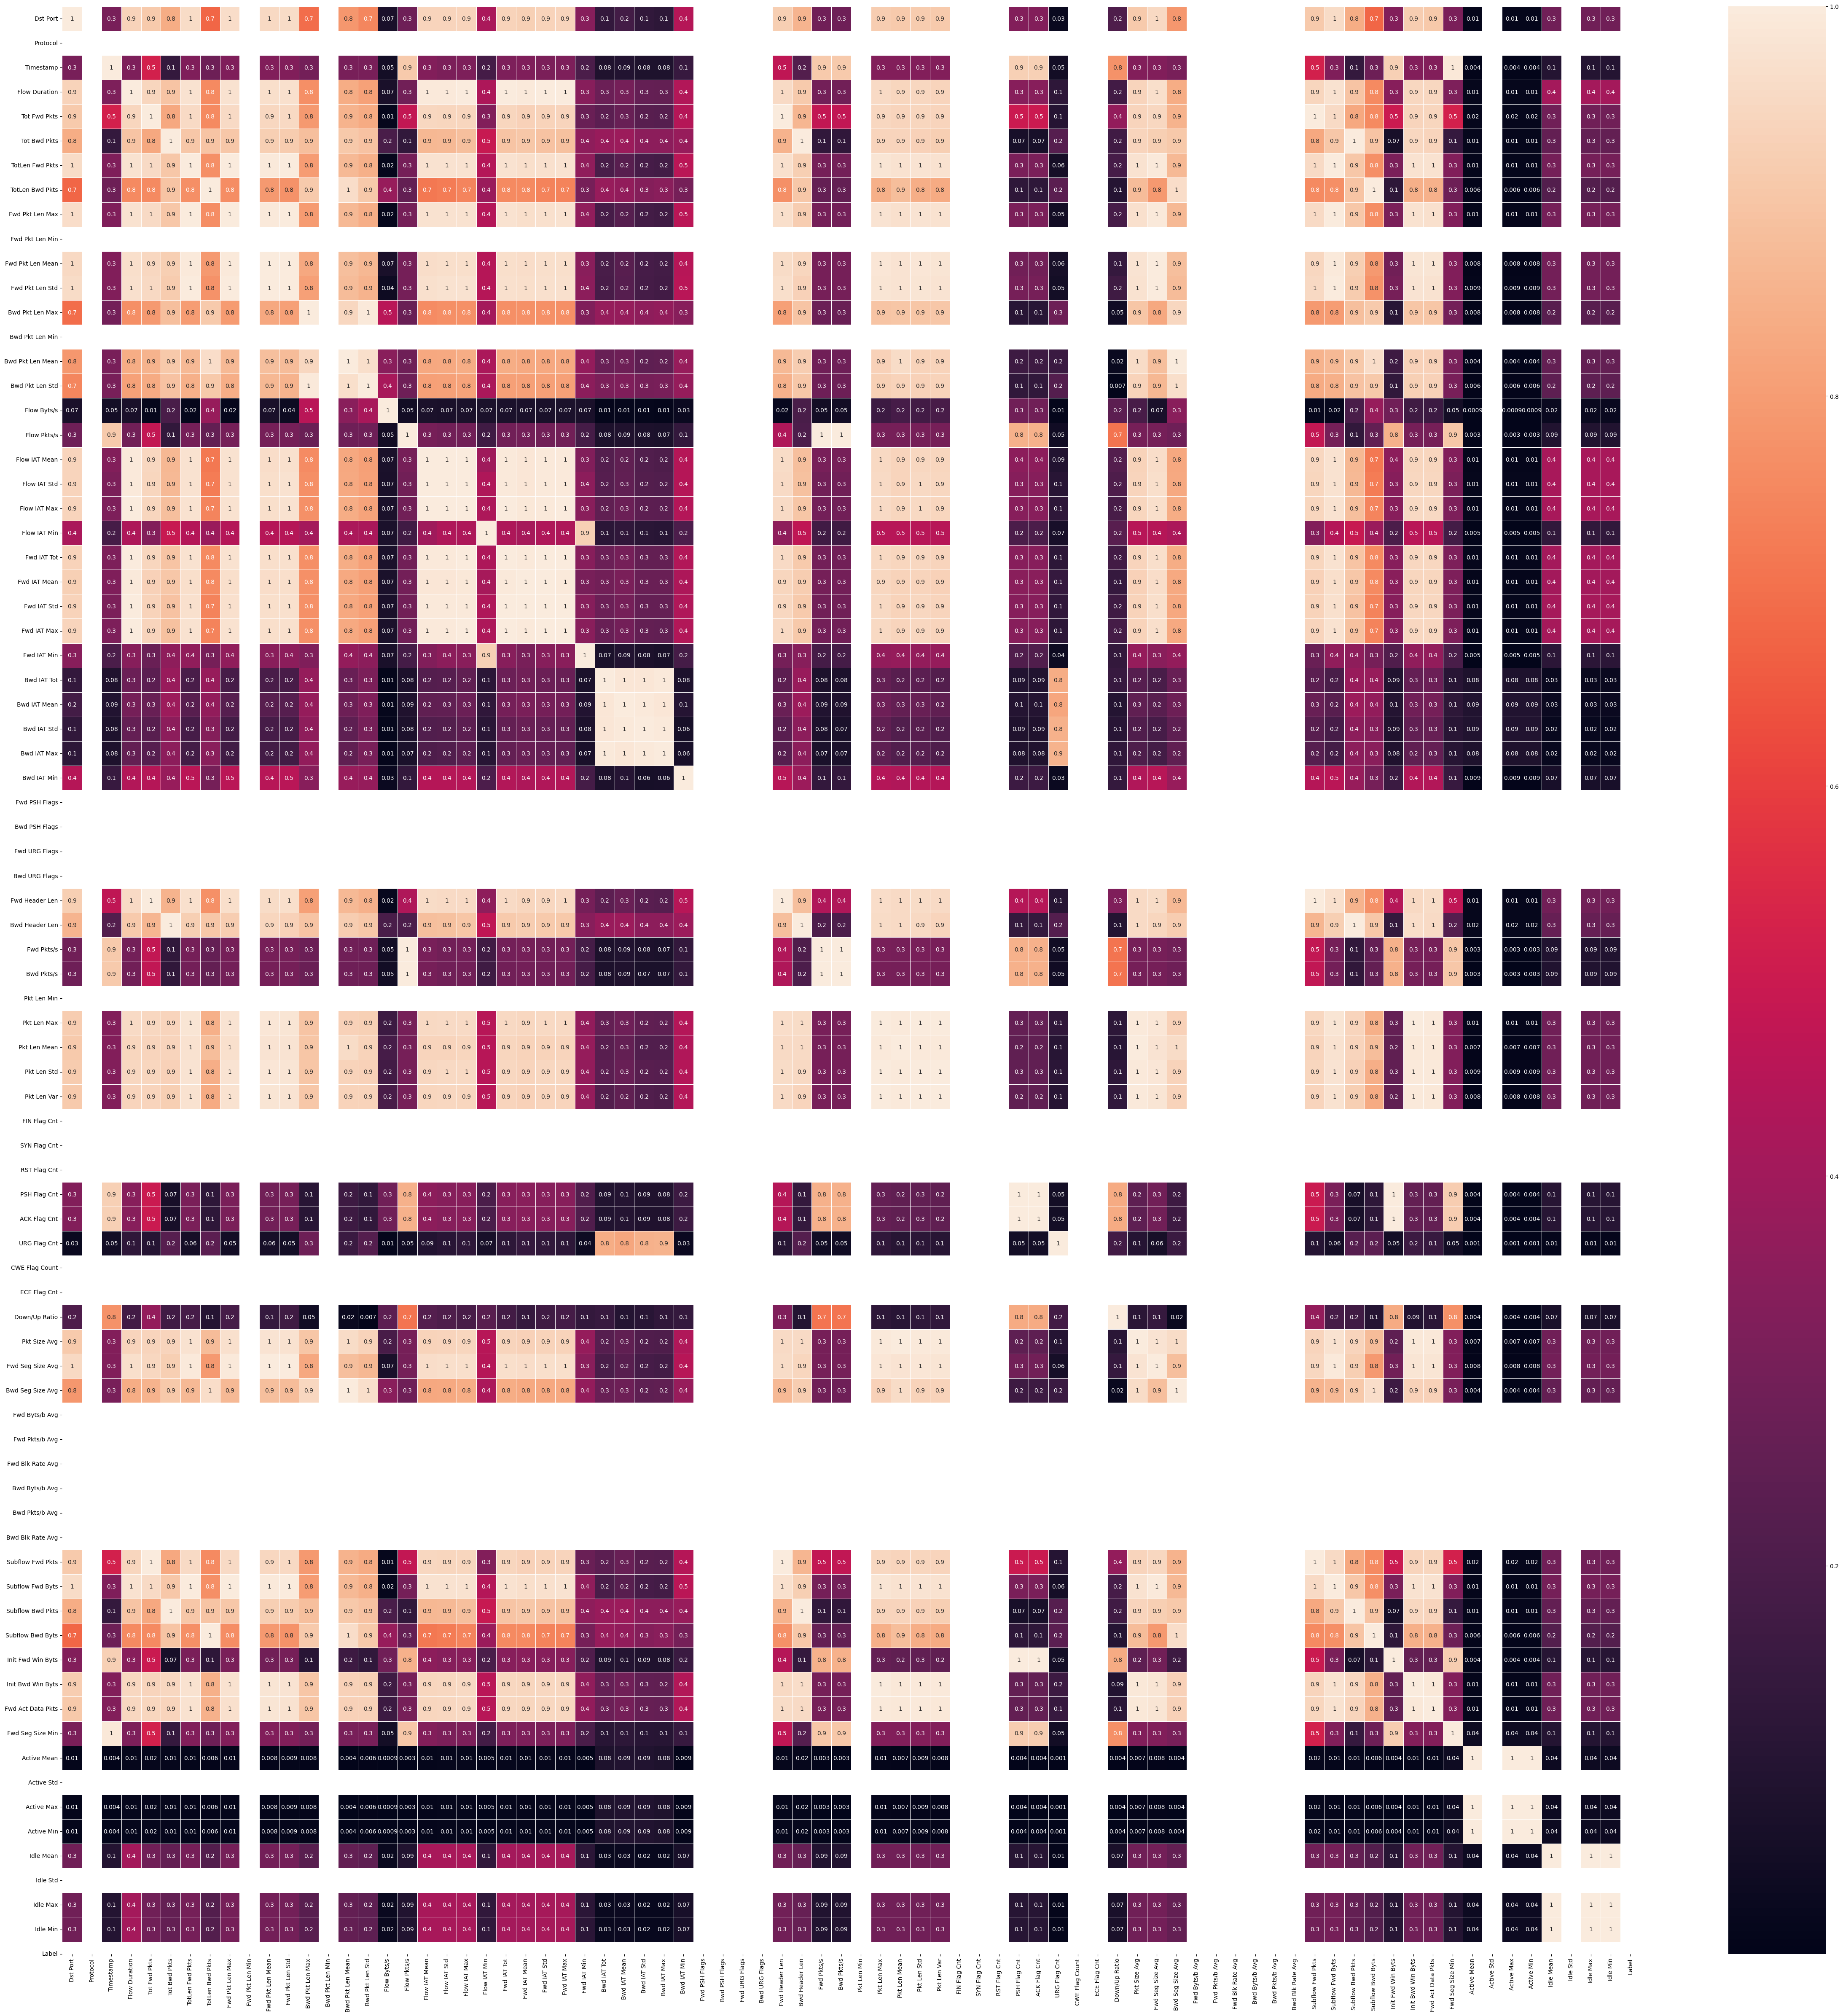

The following 36 features will be dropped due to high correlation: ['Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Max', 'Active Min', 'Idle Max', 'Idle Min']


In [ ]:
#Highly correlated features filtered out
columns = [col for col in df.columns if col != 'Label']

corr_matrix = df[columns].corr().abs()


matrix = np.array(corr_matrix)
cols = list(df.columns)
fig, ax = plt.subplots(figsize=(60, 60))
ax = sns.heatmap(matrix, linewidth=0.5, annot = True, fmt='.1g',xticklabels=cols,yticklabels=cols)
plt.show()

threshold = 0.99
#high threshold of 0.99 set
# Find features with high correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Print features to drop
print(f"The following {len(to_drop)} features will be dropped due to high correlation: {to_drop}")

df = df.drop(to_drop, axis = 1)

# replace +ve and -ve infinity with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop all NaN values
df.dropna(inplace=True)

In [ ]:
df["Label"] = df.Label.map(lambda a:"normal" if a == 'Benign' else "attack")

In [ ]:
df = df.sample(frac=1) #Randomize rows's sequence

df2 = df[df["Label"] == "attack"]

df0 = df[df["Label"] == "normal"]
df2 = df2[:df0.shape[0]]

df = pd.concat([ df0,df2], axis =0)

In [ ]:
print(f"{df['Label'].value_counts()}\n")
display(df.describe())
display(df.head())
display(df.info())

normal    329457
attack    329457
Name: Label, dtype: int64



,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Min,Bwd Pkt Len Max,...,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Active Mean,Active Std,Idle Mean,Idle Std
count,658914.000000,658914.0,658914.000000,658914.000000,658914.000000,658914.000000,658914.000000,658914.000000,658914.0,658914.000000,...,658914.0,658914.0,658914.0,658914.0,658914.0,658914.0,658914.000000,658914.0,658914.000000,658914.0
mean,0.385930,0.0,0.125714,0.177421,0.306231,0.185073,0.285084,0.086676,0.0,0.196843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000042,0.0,0.071484,0.0
std,0.396447,0.0,0.235051,0.177776,0.197336,0.167476,0.279512,0.099961,0.0,0.210055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004145,0.0,0.251596,0.0
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
25%,0.000968,0.0,0.045127,0.000340,0.125000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
50%,0.000968,0.0,0.046149,0.241396,0.375000,0.300000,0.227053,0.118990,0.0,0.303279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
75%,0.767453,0.0,0.047172,0.338885,0.500000,0.300000,0.564614,0.141827,0.0,0.358607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Min,Bwd Pkt Len Max,...,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Active Mean,Active Std,Idle Mean,Idle Std,Label
607957,0.772012,0.0,0.046807,0.339548,0.5,0.3,0.564614,0.152644,0.0,0.390369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,normal
155340,0.759909,0.0,0.044373,0.420375,0.5,0.3,0.564614,0.163862,0.0,0.419057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.955697,0.0,normal
324054,0.656920,0.0,0.045297,0.337635,0.5,0.3,0.564614,0.131811,0.0,0.337090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,normal
126838,0.735179,0.0,0.044251,0.412606,0.5,0.3,0.564614,0.115385,0.0,0.295082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.937333,0.0,normal
311846,0.828165,0.0,0.045249,0.314920,0.5,0.3,0.564614,0.115385,0.0,0.295082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,normal


<class 'pandas.core.frame.DataFrame'>
Int64Index: 658914 entries, 607957 to 394043
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Dst Port          658914 non-null  float64
 1   Protocol          658914 non-null  float64
 2   Timestamp         658914 non-null  float64
 3   Flow Duration     658914 non-null  float64
 4   Tot Fwd Pkts      658914 non-null  float64
 5   Tot Bwd Pkts      658914 non-null  float64
 6   TotLen Fwd Pkts   658914 non-null  float64
 7   TotLen Bwd Pkts   658914 non-null  float64
 8   Fwd Pkt Len Min   658914 non-null  float64
 9   Bwd Pkt Len Max   658914 non-null  float64
 10  Bwd Pkt Len Min   658914 non-null  float64
 11  Bwd Pkt Len Mean  658914 non-null  float64
 12  Flow Byts/s       658914 non-null  float64
 13  Flow Pkts/s       658914 non-null  float64
 14  Flow IAT Min      658914 non-null  float64
 15  Fwd IAT Min       658914 non-null  float64
 16  Bwd IAT Tot    

None

In [ ]:
# Round the numeric columns to the specified decimal places
df_rounded = df.round(5)

In [ ]:
display(df_rounded.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658914 entries, 607957 to 394043
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Dst Port          658914 non-null  float64
 1   Protocol          658914 non-null  float64
 2   Timestamp         658914 non-null  float64
 3   Flow Duration     658914 non-null  float64
 4   Tot Fwd Pkts      658914 non-null  float64
 5   Tot Bwd Pkts      658914 non-null  float64
 6   TotLen Fwd Pkts   658914 non-null  float64
 7   TotLen Bwd Pkts   658914 non-null  float64
 8   Fwd Pkt Len Min   658914 non-null  float64
 9   Bwd Pkt Len Max   658914 non-null  float64
 10  Bwd Pkt Len Min   658914 non-null  float64
 11  Bwd Pkt Len Mean  658914 non-null  float64
 12  Flow Byts/s       658914 non-null  float64
 13  Flow Pkts/s       658914 non-null  float64
 14  Flow IAT Min      658914 non-null  float64
 15  Fwd IAT Min       658914 non-null  float64
 16  Bwd IAT Tot    

None

In [ ]:
df_rounded.to_csv('preproc_data.csv', index = False)

# Model Building

In [ ]:
def splits_assemble(path, test_size=0.2):
    # Import dataset
    df_dataset = pd.read_csv(path)

    # Encode Labels for numeric classification
    label_encoder = LabelEncoder()
    df_dataset['Label'] = label_encoder.fit_transform(df_dataset['Label'])

    # Set a random state for sampling
    RANDOM_STATE_SEED = np.random.randint(123)
    print(f'Random Seed:{RANDOM_STATE_SEED}')

    # Split dataset in train and test
    train, test = train_test_split(df_dataset, test_size=test_size, random_state=RANDOM_STATE_SEED)

    # Count how many instances there are in each label
    print(df_dataset["Label"].value_counts())

    # Separate in X and y for better classification
    y_train = np.array(train.pop("Label"))# pop removes "Label" from the dataframe
    X_train = train.values

    print(f'Type X_train: {type(X_train)} Type y_train: {type(y_train)} Shape X_train:{X_train.shape} Shape y_train: {y_train.shape}')

    y_test = np.array(test.pop("Label")) # pop removes "Label" from the dataframe
    X_test = test.values

    print(f'Type X_test: {type(X_test)} Type y_test: {type(y_test)} Shape X_test:{X_test.shape} Shape y_test: {y_test.shape}')

    return X_train,y_train,X_test,y_test

In [ ]:
#Models are defined here : Decision Tree, Random Forest, SVM, K Nearest Neighbors, Gaussian Naive Bayes, XGBoost, Neural Network
def models_assemble(X_train):
    models = {}

    models['DT'] = DecisionTreeClassifier()
    models['RF'] = RandomForestClassifier()
    models['SVM'] = LinearSVC(max_iter=10000, dual=False,)
    models['KNN'] = KNeighborsClassifier(algorithm='ball_tree')
    models['NB'] = GaussianNB()
    models['XGB'] = xgb.XGBClassifier()
    models['NN'] = keras.Sequential([
            layers.InputLayer(input_shape=(X_train.shape[1],)),

            layers.BatchNormalization(renorm=True),
            layers.Dense(128, activation='relu'),
            layers.Dropout(rate = 0.3),
            layers.BatchNormalization(renorm=True),
            layers.Dense(64, activation='relu'),
            layers.Dropout(rate = 0.3),
            layers.BatchNormalization(renorm=True),
            layers.Dense(32, activation='relu'),
            layers.Dropout(rate = 0.3),
            layers.Dense(1, activation='sigmoid'),
        ])

    return models

In [ ]:
#Search algorithm to find optimal hyperparameters
def grids_assemble(cv=2, model=None,key=None):

    hyperparameters = {}
    hyperparameters['XGB'] = {'learning_rate': [0.9, 0.7, 0.5, 0.3, 0.1], 'n_estimators': [50,100,150,200],
                              }
    hyperparameters['DT'] = {'criterion': ['gini','entropy'], 'max_depth': [10,15,20,25,30],'splitter':['best','random']
                             }
    hyperparameters['RF'] = {'n_estimators': [50, 75, 100, 125, 150], 'criterion': ['gini','entropy'],'max_depth': [25,30]
                             }
    hyperparameters['SVM'] = { 'C': np.linspace(0.01,100, num=20)
                              }
    hyperparameters['NB'] = {'var_smoothing': np.logspace(0,-9, num=20)
                             }
    hyperparameters['KNN'] = {'n_neighbors': [8,9,10,11,12], 'weights': ['uniform','distance'], 'leaf_size': [10,100]
                            }

    classifierGRID = GridSearchCV(estimator = model, param_grid = hyperparameters[key], cv=cv, verbose=1, n_jobs=-1)
    return classifierGRID



In [ ]:
def fit_assemble(classifierGRID,X_train,y_train):
    classifierGRID.fit(X=X_train, y=y_train)

    # Print best parameters found on GridsearchCV
    print("Accuracy score on Validation set: \n")
    print(classifierGRID.best_score_ )
    print("---------------")
    print("Best performing hyperparameters on Validation set: ")
    print(classifierGRID.best_estimator_)
    print("---------------")



    fitted_model = classifierGRID.best_estimator_

    return fitted_model

In [ ]:
def NeuralNet_fit(neuralNetModel,X_train,y_train,cv=2):
    def neuralnet_create(epsilon):
        model=keras.Sequential([
                layers.InputLayer(input_shape=(X_train.shape[1],)),

                layers.BatchNormalization(renorm=True),
                layers.Dense(128, activation='relu'),
                layers.Dropout(rate = 0.3),
                layers.BatchNormalization(renorm=True),
                layers.Dense(64, activation='relu'),
                layers.Dropout(rate = 0.3),
                layers.BatchNormalization(renorm=True),
                layers.Dense(32, activation='relu'),
                layers.Dropout(rate = 0.3),
                layers.Dense(1, activation='sigmoid'),
            ])
        optimizer = tf.keras.optimizers.Adam(epsilon=epsilon)

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['binary_accuracy'],
        )
        return model

    early_stopping = callbacks.EarlyStopping(min_delta = 0.001,patience = 7,restore_best_weights = True,monitor= 'loss')
    hyperparameters = {'epochs': [50], 'batch_size': [128,256], 'callbacks':[early_stopping], 'epsilon':[0.001]}
    neuralNetModel = KerasClassifier(build_fn=neuralnet_create, epsilon=0.001)
    classifierGRID = GridSearchCV(
        estimator = neuralNetModel,
        param_grid = hyperparameters,
        cv=cv,
        verbose=1,
        n_jobs=-1,
        scoring='accuracy'
    )

    classifierGRID = classifierGRID.fit(X=X_train, y=y_train)

    # Print best parameters found on GridsearchCV
    print("Accuracy score on Validation set: \n")
    print(classifierGRID.best_score_ )
    print("---------------")
    print("Best performing hyperparameters on Validation set: ")
    print(classifierGRID.best_params_)
    print("---------------")

    fitted_model = classifierGRID.best_estimator_

    return fitted_model


In [ ]:
def metrics_assemble(fitted_model,X_test,y_test):

    predictions = fitted_model.predict(X_test)

    if predictions.dtype == 'float32':
        predictions = (fitted_model.predict(X_test) > 0.5).astype("int32")


    accuracy = accuracy_score(y_test,predictions)
    precision = precision_score(y_test,predictions, average='weighted')
    recall = recall_score(y_test,predictions,average='weighted')
    f1= f1_score(y_test,predictions,average='weighted')
    auc= roc_auc_score(y_test,predictions,average='weighted')

    return accuracy, precision, recall, f1, auc

In [ ]:
!pip install dill
import dill as pickle
# Define path to the dataset
path = 'preproc_data.csv'

# Start dictionaries to store metrics
accuracy, precision, recall, f1, auc, fit_time, eval_time, fitted_models = {}, {}, {}, {}, {}, {}, {}, {}

# Get dataset splits for training and evaluation
X_train,y_train,X_test,y_test = splits_assemble(path, test_size=0.9)

# Start dictionary for models
models=models_assemble(X_train)

# Start iteration loop for fitting and evaluating the classic models
for key in ['DT', 'RF', 'XGB', 'NB', 'SVM']:

    # Get the grid of hyperparameters and start the GridsearchCV function
    classifierGRID = grids_assemble(cv = 2, model=models[key],key=key)

    print(f'Fitting {key} model')

    # Fit model
    start_time = time.time()
    fitted_models[key] = fit_assemble(classifierGRID,X_train,y_train)
    end_time = time.time()
    fit_time[key] = end_time - start_time

    # Evaluate model
    start_time = time.time()
    accuracy[key], precision[key], recall[key], f1[key], auc[key] = metrics_assemble(fitted_models[key],X_test,y_test)
    end_time = time.time()
    eval_time[key] = end_time - start_time

# Fit the neural network model
start_time = time.time()
fitted_models['NN'] = NeuralNet_fit(models['NN'],X_train,y_train, cv = 2)
end_time = time.time()
fit_time['NN'] = end_time - start_time

# Evaluate the neural network model
start_time = time.time()
accuracy['NN'], precision['NN'], recall['NN'], f1['NN'], auc['NN'] = metrics_assemble(fitted_models['NN'],X_test,y_test)
end_time = time.time()
eval_time['NN'] = end_time - start_time

# Convert the metrics dictionaries into a dataframe for better visualization
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score':f1, 'ROC-AUC-Score': auc, \
           'Tempo':fit_time, 'Evaluation Time':eval_time}
df_metrics = pd.DataFrame(metrics)
display(df_metrics)


Random Seed:87
1    256162
0    256162
Name: Label, dtype: int64
Type X_train: <class 'numpy.ndarray'> Type y_train: <class 'numpy.ndarray'> Shape X_train:(51232, 43) Shape y_train: (51232,)
Type X_test: <class 'numpy.ndarray'> Type y_test: <class 'numpy.ndarray'> Shape X_test:(461092, 43) Shape y_test: (461092,)
Fitting DT model
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Accuracy score on Validation set: 

0.9999024047470331
---------------
Best performing hyperparameters on Validation set: 
DecisionTreeClassifier(max_depth=10)
---------------
Fitting RF model
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Accuracy score on Validation set: 

0.9999219237976265
---------------
Best performing hyperparameters on Validation set: 
RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=50)
---------------
Fitting XGB model
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Accuracy score on Validation set: 

0.9999024047470331
-----

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
401/401 [==============================] - 5s 7ms/step - loss: 0.0830 - binary_accuracy: 0.9866
Epoch 2/50
401/401 [==============================] - 3s 9ms/step - loss: 0.0025 - binary_accuracy: 0.9996
Epoch 3/50
401/401 [==============================] - 2s 5ms/step - loss: 0.0022 - binary_accuracy: 0.9999
Epoch 4/50
401/401 [==============================] - 2s 5ms/step - loss: 8.1453e-04 - binary_accuracy: 0.9999
Epoch 5/50
401/401 [==============================] - 2s 4ms/step - loss: 8.2447e-04 - binary_accuracy: 0.9999
Epoch 6/50
401/401 [==============================] - 2s 4ms/step - loss: 7.9704e-04 - binary_accuracy: 0.9999
Epoch 7/50
401/401 [==============================] - 2s 5ms/step - loss: 7.7047e-04 - binary_accuracy: 0.9999
Epoch 8/50
401/401 [==============================] - 3s 7ms/step - loss: 6.1591e-04 - binary_accuracy: 0.9999
Epoch 9/50
401/401 [==============================] - 2s 4ms/step - loss: 6.5593e-04 - binary_accuracy: 0.9999
Epoch 10/50
4

,Accuracy,Precision,Recall,F1-Score,ROC-AUC-Score,Tempo,Evaluation Time
DT,0.999987,0.999987,0.999987,0.999987,0.999987,3.050949,0.914113
RF,0.999985,0.999985,0.999985,0.999985,0.999985,58.250314,2.771525
XGB,0.999889,0.999889,0.999889,0.999889,0.999889,21.294207,1.186769
NB,0.995636,0.995673,0.995636,0.995636,0.995635,2.011470,1.134697
SVM,0.999965,0.999965,0.999965,0.999965,0.999965,3.278157,1.332440
NN,0.999970,0.999970,0.999970,0.999970,0.999970,91.527873,28.663314


# Adversarial Deep Learning

## CNN original

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
import torch

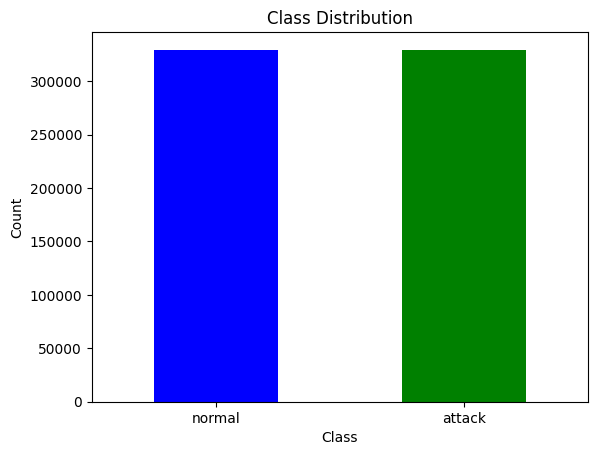

In [ ]:
df_CNN = pd.read_csv('preproc_data.csv')


In [ ]:
df_CNN.shape
df_CNN_f  = df_CNN.groupby('Label', group_keys=False).apply(lambda df_CNN: df_CNN.sample(20000))
print(df_CNN_f.shape)
print(f"{df_CNN_f['Label'].value_counts()}\n")
df_CNN_f = df_CNN_f.sample(frac=1)
df_CNN_f.head()

(40000, 44)
attack    20000
normal    20000
Name: Label, dtype: int64



,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Min,Bwd Pkt Len Max,...,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Active Mean,Active Std,Idle Mean,Idle Std,Label
374539,0.00097,0.0,0.04425,0.00002,0.125,0.0,0.00000,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,attack
92843,0.81373,0.0,0.04722,0.32109,0.500,0.3,0.56461,0.13181,0.0,0.33709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
585542,0.00000,0.0,0.82348,0.00000,0.000,0.1,0.00000,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,attack
152822,0.89150,0.0,0.04532,0.10314,0.500,0.4,0.56461,0.14824,0.0,0.37910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
57093,0.74062,0.0,0.04681,0.35004,0.500,0.4,0.56461,0.29327,0.0,0.37500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal


In [ ]:
label_encoder = LabelEncoder()
df_CNN_f['Label']= label_encoder.fit_transform(df_CNN_f['Label'])
df_CNN_f['Label'].unique()
train, test = train_test_split(df_CNN_f, test_size=0.2, random_state=np.random.randint(123))
df_CNN_f.head()


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Min,Bwd Pkt Len Max,...,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Active Mean,Active Std,Idle Mean,Idle Std,Label
374539,0.00097,0.0,0.04425,0.00002,0.125,0.0,0.00000,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
92843,0.81373,0.0,0.04722,0.32109,0.500,0.3,0.56461,0.13181,0.0,0.33709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
585542,0.00000,0.0,0.82348,0.00000,0.000,0.1,0.00000,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
152822,0.89150,0.0,0.04532,0.10314,0.500,0.4,0.56461,0.14824,0.0,0.37910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
57093,0.74062,0.0,0.04681,0.35004,0.500,0.4,0.56461,0.29327,0.0,0.37500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
num_classes = 2
learning_rate = 0.001
epochs = 10
batch_size = 32

# attack side hyperparam
epsilon = 0.5
# slice size for crossover
eta_h = 0.5
eta_w = 0.5
delta = 10

lamda = 0.1

pop_size = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

max_iter = 10

In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np

from torch.utils.data import Dataset
import torch
import pandas as pd
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, data, df_row=None, transform=None):
        if not torch.is_tensor(data):
            data = torch.tensor(data.values, dtype=torch.float)
        self.data = data

        if df_row is not None:
            if not torch.is_tensor(df_row):
                df_row = torch.tensor(df_row, dtype=torch.float)
            # Reshape df_row to match the number of channels (32 channels)
            df_row = df_row.view(32, 44)
            self.data = torch.cat([self.data, df_row], dim=0)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        individual = self.data[index]

        if self.transform is not None:
            individual = self.transform(individual)

        # Extract the label (the last element)
        label = individual[-1]

        # Remove the label from the data
        input_data = individual[:-1]

        sample = {'input': input_data, 'label': label}

        return sample



In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler

def train_test_split_custom(dataframe, valid_size=0.2, batch_size=batch_size):
    # Determine the number of samples in the dataset
    num_samples = len(dataframe)
    split = int(np.floor(valid_size * num_samples))
    indices = list(range(num_samples))
    np.random.shuffle(indices)

    # Split the indices into training and testing sets
    train_indices, test_indices = indices[split:], indices[:split]

    # Create data samplers for the training and testing sets
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    dataframe_py = CustomDataset(dataframe)
    # Create DataLoader objects for training and testing
    train_loader = DataLoader(dataframe_py, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataframe_py, batch_size=batch_size, sampler=test_sampler)

    return train_loader, test_loader

# Example usage:
# train_loader, test_loader = train_test_split(dataframe, valid_size=0.2, batch_size=batch_size)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CustomConvNet1D model
class CustomConvNet1D(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomConvNet1D, self).__init__()

        # 1D Convolutional Layers
        self.conv1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)

        # Max-pooling Layer
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Calculate the input size for the fully connected layers
        # Adjusted based on spatial dimensions
        self.fc_input_size = 128

        # Fully Connected Layers
        self.fc1 = nn.Linear(36, 18)  # Correct input size
        self.fc2 = nn.Linear(18, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(32, -1)  # Reshape to (batch_size, -1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x






In [ ]:
def create_model():
    model_c = CustomConvNet1D()
    return model_c


In [ ]:
from torch import nn
from torchvision import models
import torch.optim as optim
def train_loop(train_loader, test_loader, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(epochs):
      model.train()
      running_loss = 0.0
      for batch in train_loader:
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)
        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

      print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Evaluation (testing) phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return model, accuracy

In [ ]:
CNN = create_model()
print("start")
train_loader, test_loader = train_test_split_custom(df_CNN_f)
CNN_orig, acc = train_loop(train_loader, test_loader, model=CNN)

start
Epoch 1/10, Loss: 0.3528836985565722
Epoch 2/10, Loss: 0.07288566236197948
Epoch 3/10, Loss: 0.06275446236133575
Epoch 4/10, Loss: 0.05733274687454105
Epoch 5/10, Loss: 0.051419606616720556
Epoch 6/10, Loss: 0.04653503184206784
Epoch 7/10, Loss: 0.043648132789880036
Epoch 8/10, Loss: 0.04417181348614395
Epoch 9/10, Loss: 0.043033533565700055
Epoch 10/10, Loss: 0.03954543120227754
Test Accuracy: 98.00%


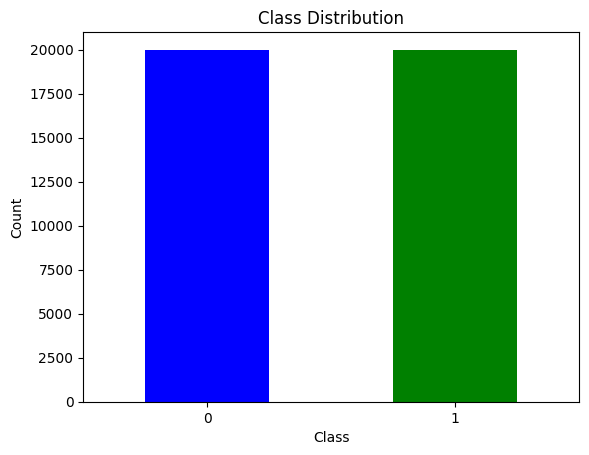

In [ ]:
class_distribution = df_CNN_f['Label'].value_counts()

# Plot the class distribution
class_distribution.plot(kind='bar', color=['blue', 'green'])  # Adjust colors as needed
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # If you want class labels to be displayed horizontally
plt.show()

In [ ]:
class PopObj:
    def __init__(self, individual):
        self.individual = individual
        self.fitness = 1e-10

def change(individuals, alpha):
    result_individuals = individuals.copy()
    # Append the dataset represented by alpha to the individuals DataFrame
    result_individuals = result_individuals.append(alpha.individual, ignore_index=True)

    return result_individuals

In [ ]:
import random
epsilon = 0.5
def selection(alpha_pop: list[PopObj], epsilon=0.5):
    W = [a.fitness for a in alpha_pop]
    W = np.array(W)
    min_val = np.min(W)
    max_val = np.max(W)
    W = (W - min_val) / (max_val - min_val)
    W = W / np.sum(W)
    proportion = int(epsilon * len(alpha_pop))

    selected_pop = random.choices(alpha_pop, k=proportion, weights=W)
    P1 = [i for i in alpha_pop if i not in selected_pop]

    return P1, selected_pop


In [ ]:
import torch

def crossover_df(c1, c2):
    # Create new individuals by merging attributes of c1 and c2
    merged_individual = c1.individual.clone()

    # Exclude the last column from crossover by setting the mask
    mask = torch.randint(2, size=merged_individual[:, :-1].shape, dtype=torch.bool)
    merged_individual[:, :-1][mask] = c2.individual[:, :-1][mask]

    # Ensure the last column (column -1) remains unaffected
    child1 = PopObj(merged_individual)

    merged_individual = c2.individual.clone()

    # Exclude the last column from crossover by setting the mask
    mask = torch.randint(2, size=merged_individual[:, :-1].shape, dtype=torch.bool)
    merged_individual[:, :-1][~mask] = c1.individual[:, :-1][~mask]

    # Ensure the last column (column -1) remains unaffected
    child2 = PopObj(merged_individual)

    return child1, child2



In [ ]:
import torch

def mutation(m):
    step = 0.001 * torch.rand(1)

    # Exclude the last column from mutation by setting the mask
    mask = torch.rand(m.individual[:, :-1].shape) > 0.5
    m.individual[:, :-1][mask] += step

    return m



In [ ]:
import torch
num_classes = 2
learning_rate = 0.001
epochs = 10
batch_size = 32

# attack side hyperparam
epsilon = 0.5
# slice size for crossover
eta_h = 0.5
eta_w = 0.5
delta = 10

lamda = 0.5

pop_size = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

max_iter = 10
mutation_rate= 0.2

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn

In [ ]:
def new_data(train_dataloader, test_dataloader, df_rows, batch_size=batch_size):
    output = []

    train_data = train_dataloader.dataset.data
    test_data = test_dataloader.dataset.data

    train_dataset = CustomDataset(train_data, df_rows)
    test_dataset = CustomDataset(test_data, df_rows)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    output.append((train_dataloader, test_dataloader))

    return output

In [ ]:
from sklearn.metrics import recall_score
def fitness(data_loader, alpha_pop, model):
    max_fitness = -float('inf')
    print("Recall avg for each alpha:")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for alpha in alpha_pop:
        error_cumul = 0

        model.eval()
        with torch.no_grad():
            for batch in data_loader:
                inputs = batch['input'].to(device)
                labels = batch['label'].to(device)
                logps = model.forward(inputs)
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                error = recall_score(labels.view(*top_class.shape), top_class)
                error_cumul += error

        error_avg = error_cumul / len(data_loader)
        print(error_avg)

        alpha_individual = alpha.individual
        alpha.fitness = 1 + lamda * (1-error_avg) - 0.1*alpha_individual.norm()

        if alpha.fitness > max_fitness:
            max_fitness = alpha.fitness
            max_a = alpha

    return sorted(alpha_pop, key=lambda a: a.fitness, reverse=True)

In [ ]:
def save_row_as_csv(row, name):
    # Save the row as a CSV file with the given name
    row.to_csv(f'{name}.csv', index=False)

In [ ]:
def save_data_loader_rows_as_csv(train_loader, name):
    for batch in train_loader:
        # Extract the DataFrame row from the batch (assuming the row is the first element of each batch)
        row = batch[0]
        # Save the row as a CSV file in the specified directory
        row.to_csv(f'{name}.csv', index=False)

In [ ]:
maxpayoff = 0
exitloop = False
x_plot = []
y_temp=[]
y_sec=[]
j=1
# Initialize alpha population
alpha_pop = []
for _ in range(pop_size):
    alpha_pop.append(PopObj(torch.cat((0.01 * torch.rand(32, 43), torch.randint(0, 2, (32, 1), dtype=torch.float32)), dim=1)))


train_loader_new = train_loader
gen = 0

while gen < max_iter and not exitloop:
    j+=1
    x_plot.append(j)
    gen += 1
    alpha_sorted = fitness(train_loader_new, alpha_pop, CNN_orig)
    alpha_best = alpha_sorted[0]
    print(f"Best fitness: {alpha_best.fitness}\n")
    # Generate adversarial data based on the best alpha
    data_adversarial = new_data(train_loader, test_loader, alpha_best.individual)
    train_loader_new, test_loader_new = data_adversarial[0]
    #for i in train_loader_new:
     #print(i['input'].shape)

    CNN_orig.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader_new:
            inputs = batch['input'].to(device)
            labels = batch['label'].to(device)
            #print(labels.shape)
            #print("hi")
            outputs = CNN_orig(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy with adversarial test data, in original model: {accuracy}")
    assert type(train_loader_new) == torch.utils.data.DataLoader
    assert type(test_loader_new) == torch.utils.data.DataLoader
    y_temp.append(accuracy)
    print("New data created")
    CNN_temp = create_model()
    # Train CNN_temp on the adversarial data
    CNN_temp_f, ac = train_loop(train_loader_new, test_loader_new, model=CNN_temp)
    y_sec.append(ac)
    print("New CNN trained")

    # Your genetic algorithm logic for creating offsprings
    # Implement selection, crossover, and mutation as needed
    if abs(maxpayoff-alpha_best.fitness) < 4:
        curr_payoff = alpha_best.fitness
        print(f'Curr_payoff: {curr_payoff}, max_payoff: {maxpayoff}, difference: {curr_payoff-maxpayoff}')
        maxpayoff = alpha_best.fitness
        parents, offsprings = selection(alpha_pop, 0.5)

        for child1, child2 in zip(offsprings[:len(offsprings) // 2], offsprings[len(offsprings) // 2:]):
          child1, child2 = crossover_df(child1, child2)

        for mutant in offsprings:
          mutant = mutation(mutant)

        # Update alpha population with new offsprings
        alpha_pop = np.append(parents, offsprings)
    train_loader = train_loader_new
    test_loader = test_loader_new

Recall avg for each alpha:
0.9523652304088166
0.951113712538963
0.952587662118071
0.953738956118985
Best fitness: 1.1015307903289795

Accuracy with adversarial test data, in original model: 97.55101030110934
New data created
Epoch 1/10, Loss: 0.2775280275537076
Epoch 2/10, Loss: 0.06872769316312267
Epoch 3/10, Loss: 0.05394484154845362
Epoch 4/10, Loss: 0.044392345471694336
Epoch 5/10, Loss: 0.04225854460694628
Epoch 6/10, Loss: 0.0406121876321474
Epoch 7/10, Loss: 0.038663475279601824
Epoch 8/10, Loss: 0.03734397705166162
Epoch 9/10, Loss: 0.0366092546836166
Epoch 10/10, Loss: 0.035874191320611225
Test Accuracy: 99.30%
New CNN trained
Curr_payoff: 1.1015307903289795, max_payoff: 0, difference: 1.1015307903289795
Recall avg for each alpha:
0.9538761450202359
0.952791093257573
0.9532107980848242
0.9539099624119213
0.9524735315296555
Best fitness: 1.1013885736465454

Accuracy with adversarial test data, in original model: 97.51830958036422
New data created
Epoch 1/10, Loss: 0.29903661093

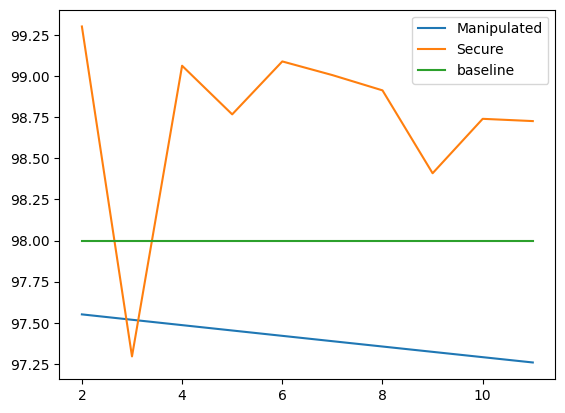

In [ ]:
y = []
for i in range(len(y_temp)):
  y.append(98.00)
plt.plot(x_plot, y_temp, label = "Manipulated")
plt.plot(x_plot, y_sec, label = "Secure")
plt.plot(x_plot, y, label = "baseline")
plt.legend()
plt.show()